# RNN作业

本次作业我们将使用PyTorch搭建RNN模型，完成简单的文本分类任务。本次作业的选做题难度较大，仅供有自然语言处理基础且时间充裕的同学完成。

截止时间：<font color=ff0000>**5.30(周一)中午** </font>

## 一、数据处理

首先导入常用软件包。

Kernel: pytorch=1.10.0 torchtext=0.11.0 python=3.9

In [38]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt 
import os
import glob
from sklearn.model_selection import train_test_split
import spacy
import numpy as np
import torchtext
from torchtext.legacy import data
from tqdm import tqdm
from copy import deepcopy

本次作业使用的数据为torchtext.data中的AG_NEWS，每一行代表一个样本，三列数据分别代表：“类别”，“标题”，“正文”。该数据集中的类别有四种：“World”, “Sports”, “Business”, “Sci/Tech”，分别用数字1-4表示。

因为原始数据集较大，截取了其中一部分作为训练集和测试集，train.csv中包含6600条数据，test.csv中包含1000条数据。

使用torchtext完成数据的加载，主要使用以下三个组件：

1. Field : 主要包含以下数据预处理的配置信息，比如指定分词方法，是否转成小写，起始字符，结束字符，补全字符以及词典等等

2. Dataset : 继承自pytorch的Dataset，用于加载数据，提供了TabularDataset可以指点路径，格式，Field信息就可以方便的完成数据加载。同时torchtext还提供预先构建的常用数据集的Dataset对象，可以直接加载使用，splits方法可以同时加载训练集，验证集和测试集。

3. Iterator : 主要是数据输出的模型的迭代器，可以支持batch定制

如果在使用torchtext的过程中出现报错的情况，一种可能是由于版本问题，相关的类被移动到torchtext.legacy当中

In [3]:
#def tokenizer(text):
    #return [token.text for token in nlp.tokenizer(text)]
TEXT = torchtext.legacy.data.Field(sequential=True, batch_first=True, include_lengths=True)
LABEL = data.Field(sequential=False, batch_first=True, use_vocab=False)
#nlp=spacy.load('en_core_web_sm')

fields = [('label', LABEL), (None, None), ('text',TEXT)]  # 通过定义fields可以方便地读取数据，这里第一列为label，第三列为需要分类的text，标题暂时不需要

train_data = data.TabularDataset(path='train.csv', format='csv', fields=fields, skip_header=False)
test_data = data.TabularDataset(path='test.csv', format='csv', fields=fields, skip_header=False)
#print preprocessed text
print(vars(train_data.examples[0]))
print(vars(test_data.examples[0]))
print(train_data[0].label)


{'label': '3', 'text': ['Unions', 'representing', 'workers', 'at', 'Turner', 'Newall', 'say', 'they', 'are', "'disappointed'", 'after', 'talks', 'with', 'stricken', 'parent', 'firm', 'Federal', 'Mogul.']}
{'label': '2', 'text': ['Six', 'players', 'from', 'both', 'Clemson', 'and', 'South', 'Carolina', 'will', 'be', 'suspended', 'for', 'one', 'game', 'next', 'season', 'for', 'their', 'participation', 'in', 'a', 'brawl', 'near', 'the', 'end', 'of', 'the', 'rivalry', 'game', 'November', '20th.']}
3


torchtext提供了构建词表的功能：我们使用50维的预训练词向量，建立词典、索引以及对应的词向量映射关系。

下载后的预训练词向量会默认存储在“.vector_cache”文件夹中。

In [5]:
#initialize glove embeddings
TEXT.build_vocab(train_data, min_freq=3, vectors="glove.6B.50d")  # 去除低频词，使用50维的预训练词向量
LABEL.build_vocab(train_data)

#No. of unique tokens in text
print("Size of TEXT vocabulary:", len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:", len(LABEL.vocab))  # 这里长度为5是因为build_vocabulary默认会添加一个<unk> token

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  # tuple中第一个元素为单词，第二个元素为对应的索引

#Word dictionary
#print(TEXT.vocab.stoi)   # stoi可以将单词转换为数字索引

Size of TEXT vocabulary: 8463
Size of LABEL vocabulary: 5
[('the', 9539), ('a', 5240), ('to', 5228), ('of', 4857), ('in', 4099), ('and', 3620), ('on', 2477), ('-', 2062), ('for', 2026), ('that', 1500)]


In [6]:
print(TEXT.vocab.vectors.shape)

torch.Size([8463, 50])


In [45]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  # 有条件的同学可以使用gpu加速训练
device='cpu'

batch_size = 64

# 划分之后的数据集，每个batch中有64个样本
train_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, test_data),
    batch_size=batch_size,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device=device)

### 词向量小练习

glove.6B.50d.txt中每一行表示：单词 50维词向量

gensim支持word2vec格式，因此需要先转换glove格式的词向量文件

In [8]:
import gensim
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# 格式转换
glove_input_file = '.vector_cache\glove.6B.50d.txt'
word2vec_output_file = '.vector_cache\glove.6B.50d.word2vec.txt'
(count, dimensions) = glove2word2vec(glove_input_file, word2vec_output_file)

# 加载词向量
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

C:\Users\G1\AppData\Local\Temp\ipykernel_20556\1157181036.py:8: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  (count, dimensions) = glove2word2vec(glove_input_file, word2vec_output_file)


In [9]:
print(glove_model.vectors.shape)
print(glove_model.key_to_index['boring'])


(400000, 50)
12217


词向量的加减可以得到有趣的结果，一个著名例子是公式：king - man + woman

In [10]:
result = glove_model.most_similar(positive=['woman', 'king'], negative=['man']) 
print(result)

[('queen', 0.8523604273796082), ('throne', 0.7664334177970886), ('prince', 0.7592144012451172), ('daughter', 0.7473882436752319), ('elizabeth', 0.7460220456123352), ('princess', 0.7424570322036743), ('kingdom', 0.7337412238121033), ('monarch', 0.721449077129364), ('eldest', 0.7184861898422241), ('widow', 0.7099431157112122)]


**请自由尝试几个其他的词向量加减例子**

In [11]:
# TODO
glove_model.most_similar(positive=['elizabeth','man'],negative=['woman'])

[('henry', 0.8805059790611267),
 ('edward', 0.8613390922546387),
 ('sir', 0.8333353400230408),
 ('william', 0.83282870054245),
 ('george', 0.8290311694145203),
 ('john', 0.826171338558197),
 ('james', 0.8212572932243347),
 ('charles', 0.8201537728309631),
 ('margaret', 0.8104661703109741),
 ('francis', 0.7973147630691528)]

In [12]:
print(glove_model.doesnt_match("beautiful nice eat fabulous".split()))

eat


In [13]:
print(glove_model.similarity('freedom','liberty'))

0.7078208


In [14]:
glove_model.similar_by_word('priest')

[('pastor', 0.8129140138626099),
 ('priests', 0.8018864989280701),
 ('bishop', 0.7970655560493469),
 ('catholic', 0.7919538021087646),
 ('clergyman', 0.782841145992279),
 ('ordained', 0.7594713568687439),
 ('church', 0.7408745288848877),
 ('clergy', 0.7377505302429199),
 ('nun', 0.7362511157989502),
 ('monk', 0.7252494692802429)]

In [15]:
sentence_biden = 'Biden speaks to the media'.lower().split()
sentence_president = 'The president of the US greets the press'.lower().split()
glove_model.wmdistance(sentence_biden,sentence_president)

0.6807771472348287

**请通过合适的方法将词向量降至2或3维，在空间坐标中显示出下列单词的位置，进行词向量可视化**

(10, 50)
(10, 2)


Text(0.5, 1.0, 'Visualization of 50-D word vectors')

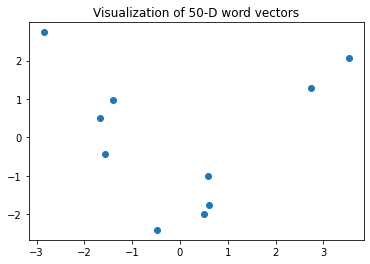

In [16]:
from sklearn.decomposition import PCA

words = ["cat", "dog", "fish", "kitten", "man", "woman",
         "king", "queen", "doctor", "nurse"]
wordar=np.zeros(len(words))
for i in range(len(words)):
    wordar[i]=glove_model.key_to_index[words[i]]
wordar=wordar.astype('int32')
M=glove_model.vectors[wordar]
print(M.shape)
pca=PCA(n_components=2)
N=pca.fit_transform(M)
print(N.shape)
plt.scatter(N[:,0],N[:,1])
plt.title('Visualization of 50-D word vectors')

## 二、RNN模型搭建

这里参考课件上的代码搭建了一个简单的RNN模型

1. 每次读取一个单词，因此RNN的输入维度为50（即词向量的维度）再加上hidden_size
2. 最终的输出维度为4（对应四个类别）
3. 初始隐状态可以用零向量

有需要的话可以自由修改

In [69]:
class RNN(nn.Module):
    def __init__(self, embedding_dim=50, hidden_size=128, output_size=4):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(embedding_dim + hidden_size, hidden_size)
        self.i2o = nn.Linear(embedding_dim + hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input_, hidden):
        combined = torch.cat((input_, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
        
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)  # 初始化全0的隐状态向量

## 三、模型训练

In [46]:
def train_step(model, batch_data, optimizer, criterion):
    optimizer.zero_grad()
    total_loss = 0
    total_acc = 0

    # 载入数据
    texts, text_lengths = batch_data.text  # texts当中存储的是单词的数字索引，来自于Field的提取形式
    labels = batch_data.label
        
    #print(labels)
    #print(texts, text_lengths)
    #print(len(text_lengths))
    
    for text, label in zip(texts, labels):
        hidden = model.init_hidden().to(device)  # 创建一个初始隐状态,大小为1x128
        # 每次输入batch中的一个样本
        for i in range(len(text)):
            embedding = TEXT.vocab.vectors[text[i]]  # 根据text中的数字索引获得对应的词向量，尺寸为(128,)
            embedding = embedding.to(device)
            # print(embedding)
            output, hidden = model(embedding.reshape(1, -1), hidden)  # 变换词向量的维度，使其能和hidden tensor拼接起来
        target = (label - 1).unsqueeze(0)  # 原始label是1~4，减1之后对应下标0~3
        loss = criterion(output, target)   # 计算loss
        loss.backward(retain_graph=True)
        
        total_loss += loss.item()
        
        if output.argmax(1) == label - 1:  # 判断模型预测的概率最大的类是否正确,output的维度是1xtext_length
            total_acc += 1
    
    optimizer.step()
    
    return total_loss / len(batch_data), total_acc / len(batch_data)



In [35]:
a=torch.tensor([[1,2,3],[4,5,6]])
print(a.unsqueeze(0).shape)
print(a.argmax(1))

torch.Size([1, 2, 3])
tensor([2, 2])


在训练过程中，我们希望能够保存效果最好的模型，使用save()和load()函数可以实现模型的保存和加载。

参考文档：https://pytorch.org/tutorials/beginner/saving_loading_models.html

**请实现：保存训练过程中loss最小的模型**

考虑到训练阶段运行时间可能比较长，同学们可以自行选择合适的epoch数。本次作业旨在让大家熟悉基本模型结构，模型最终的表现效果不会成为评分指标。

In [73]:
def train(model, iterator, lr=0.01, num_epoch=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    loss_arr = []
    acc_arr = []
    epoch_acc = 0
    
    # set the model in training phase
    model.train()
    best_state=deepcopy(model.state_dict())
    best_epoch=0
    min_loss=5
    for epoch in range(num_epoch):
        mean_acc = []
        mean_loss = []
        for i, batch_data in enumerate(iterator):
            batch_loss, batch_acc = train_step(model, batch_data, optimizer, criterion)
            loss_arr.append(batch_loss)
            mean_loss.append(batch_loss)
            if (i + 1) % 10 == 0:
                print("Iteration number:", i + 1,'Loss:', batch_loss, "Acc:", batch_acc)
            mean_acc.append(batch_acc)
            acc_arr.append(batch_acc)
            if batch_loss<min_loss:
                best_state=deepcopy(model.state_dict())
                best_iter=epoch*(6600//64+1)+(i+1)
                min_loss=batch_loss
        print("Epoch Acc:", np.mean(mean_acc), "Epoch loss", np.mean(mean_loss))
        
        
        print('The best model until now from:',best_iter,'Min loss:',min_loss)
        # TODO: 保存loss最小的模型
    
    torch.save(best_state,'RNN_model_dict.txt')
    
    # 绘制loss曲线
    plt.figure(figsize=(15,8))
    plt.plot(loss_arr, "-*")
    plt.plot(acc_arr)
    plt.legend(['loss','acc'])
    plt.xlabel("Iteration",fontsize=15)
    plt.ylabel("Loss & Accuracy",fontsize=15)
    plt.vlines(best_iter,0,2,linestyles='dashed',color='blue')
    plt.hlines(1,0,epoch*(6600//64+1)+(i+1),linestyles='dashed',color='orange')
    plt.show()
    

Iteration number: 10 Loss: 1.3816250916570425 Acc: 0.1875
Iteration number: 20 Loss: 1.3723514825105667 Acc: 0.34375
Iteration number: 30 Loss: 1.367883212864399 Acc: 0.390625
Iteration number: 40 Loss: 1.238487333059311 Acc: 0.421875
Iteration number: 50 Loss: 1.2997424388304353 Acc: 0.328125
Iteration number: 60 Loss: 1.1874716933816671 Acc: 0.59375
Iteration number: 70 Loss: 1.2210369603708386 Acc: 0.5625
Iteration number: 80 Loss: 1.1129793897271156 Acc: 0.65625
Iteration number: 90 Loss: 1.173711915500462 Acc: 0.53125
Iteration number: 100 Loss: 1.1693161129951477 Acc: 0.5625
Epoch Acc: 0.4660456730769231 Epoch loss 1.2593976438152963
The best model until now from: 85 Min loss: 1.0810970319435
Iteration number: 10 Loss: 1.0965053476393223 Acc: 0.609375
Iteration number: 20 Loss: 1.0181836355477571 Acc: 0.734375
Iteration number: 30 Loss: 1.2928839046508074 Acc: 0.421875
Iteration number: 40 Loss: 1.382042795419693 Acc: 0.375
Iteration number: 50 Loss: 1.3530433624982834 Acc: 0.390

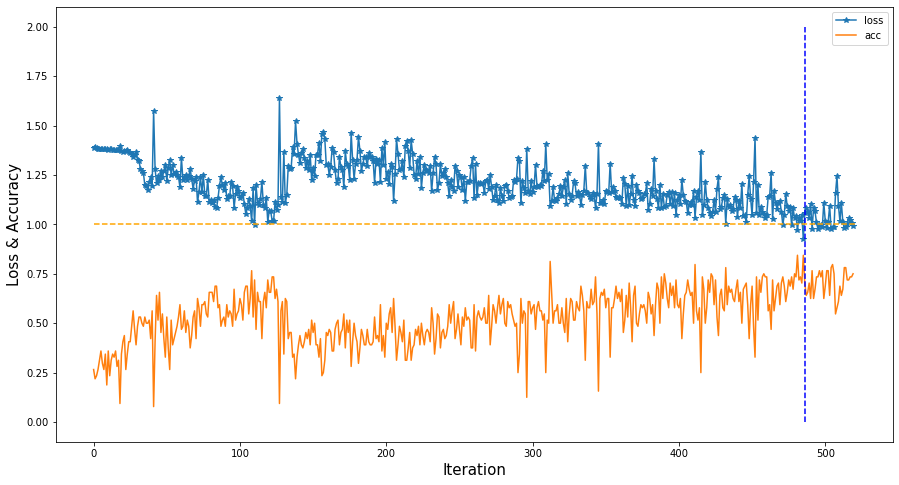

In [74]:
# RNN训练 具体的参数可以自行调整
n_hidden = 128
n_input = 50
n_output = 4
rnn = RNN(n_input, n_hidden, n_output)
rnn.to(device)
train(rnn, train_iterator, lr=0.0005, num_epoch=5)


## 四、结果评测

计算RNN模型在测试集上的准确率：

In [75]:
def eval_test(model, iterator):
    total_cnt = 0
    total_acc = 0
    for batch_data in iterator:
        texts, text_lengths = batch_data.text
        labels = batch_data.label
        
        for text, label in zip(texts, labels):
            hidden = model.init_hidden().to(device)
            for i in range(len(text)):
                embedding = TEXT.vocab.vectors[text[i]]
                embedding = embedding.to(device)
                output, hidden = model(embedding.reshape(1, -1), hidden)
            
            if output.argmax(1) == label - 1:  # 判断预测概率最大的类是否正确
                total_acc += 1
            total_cnt += 1

    print("Test Acc:", total_acc / total_cnt)

**请加载效果最好的模型，输出模型在测试集上的准确率**

In [76]:
# TODO
best_model=RNN()
best_model.load_state_dict(torch.load('RNN_model_dict.txt'))
eval_test(best_model, test_iterator)

Test Acc: 0.702


## 五、附加部分（1'）

**可选1 模型优化**：在上述文本分类任务中，只使用了文章的正文内容，没有利用标题中的信息。请尝试加入标题内容，修改模型，以优化模型的分类能力。

**可选2 对抗实验**：训练完成后，我们可以得到一个模型能够正确预测的样本构成的集合，请在已有的模型能够正确分类的样本集中设计一些对抗实验。

例如：对原始的输入文本随机删去一些词，或是将部分词遮盖（替换）成&lt;unk&gt;，表示未知词。（前面用torchtext构建的TEXT.vocab词表中第一个token是&lt;unk&gt;）

这部分可以设置一个适当的比例，比如遮盖/删除20%的词。计算模型对于这样的输入的预测错误率，并尝试改进策略，使得模型在面对“20%的词被遮盖”（或者其他条件）的情况时，错误预测率尽可能低。